In [1]:

import os

from pathlib import Path
from collections import defaultdict
import duckdb
import numpy as np
import pandas as pd
import igraph as ig
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

from event import Event

from dotenv import load_dotenv

load_dotenv()

PROJECT_DIR = Path("~/tramita").expanduser()
DB_PATH = PROJECT_DIR / os.getenv("SILVER_DUCKDB_PATH", "")
OUT_DIR = PROJECT_DIR / "data" / "gold"
OUT_DIR.mkdir(exist_ok=True)
ACCESS_DIR = OUT_DIR / "accessory_data"
ACCESS_DIR.mkdir(exist_ok=True)

NODES_PATH_PARQUET = OUT_DIR / "nodes.parquet"
EDGES_PATH_PARQUET = OUT_DIR / "edges.parquet"
NODES_PATH_CSV = OUT_DIR / "nodes.csv"
EDGES_PATH_CSV = OUT_DIR / "edges.csv"

# with duckdb.connect(DB_PATH, read_only=True) as con:

In [2]:
def merge_nodes(nodes_df: pd.DataFrame, edges_df: pd.DataFrame, taglist: list[str]) -> None:
    surviving_tag = taglist[0]
    for removed_tag in taglist[1:]:
        edges_df.loc[edges_df['source'] == removed_tag, 'source'] = surviving_tag
        edges_df.loc[edges_df['target'] == removed_tag, 'target'] = surviving_tag

    nodes_df.drop(index=taglist[1:], inplace=True)
    

def prune_graph(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    def _prune_nodes(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
        return node_df[
            (node_df['name'].isin(edge_df['from']))
            | (node_df['name'].isin(edge_df['to']))
        ]
        
        
    def _prune_edges(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
        return edge_df[
            (edge_df['from'].isin(node_df['name']))
            & (edge_df['to'].isin(node_df['name']))
        ]

    while True:
        n = len(node_df)
        m = len(edge_df)
        node_df = _prune_nodes(node_df, edge_df)
        edge_df = _prune_edges(node_df, edge_df)
        if n == len(node_df) and m == len(edge_df):
            return node_df, edge_df
        
def build_graph(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> ig.Graph:
    edge_tuples = list(zip(edge_df['from'], edge_df['to']))
    g = ig.Graph.TupleList(
        edge_tuples,
        directed=False,
        vertex_name_attr="name",
        weights=True,
    )
    for col in node_df.columns:
        if col != "name":
            g.vs[col] = node_df.set_index("name").loc[g.vs['name'], col].tolist()

    for col in edge_df.columns:
        if col not in ("from", "to"):
            g.es[col] = edge_df[col].tolist()
    
    return g

def get_community(g: ig.Graph) -> ig.VertexClustering:
    community_method = None
    try:
        cl = g.community_leiden(objective_function="modularity")
        community_method = "leiden"
    except Exception:
        cl = g.community_multilevel()  # Louvain
        community_method = "louvain"
    
    print(f"Community method used: {community_method}")
    return cl

def get_metrics(g: ig.Graph) -> pd.DataFrame:
    vcount = g.vcount()
    components = g.components()
    component_sizes = pd.Series([len(c) for c in components], name="size").to_frame()
    component_sizes["component_id"] = component_sizes.index
    component_sizes = component_sizes[["component_id","size"]].sort_values("size", ascending=False).reset_index(drop=True)
    
    comp_id_map = {}
    for cid, comp in enumerate(components):
        for vid in comp:
            comp_id_map[vid] = cid
    
    degree_all = g.degree()
    pagerank = g.pagerank(weights='weight', directed=False)

    return pd.DataFrame({
        "id":                 g.vs["name"],
        "type":               g.vs["type"],
        "label": g.vs["label"],
        "degree":             degree_all,
        "pagerank":        pagerank,
        "component_id":       [comp_id_map[i] for i in range(vcount)],
    })
    
def top_n(df: pd.DataFrame, col: str, n: int = 10, node_types: list | None = None) -> pd.DataFrame:
    sub = df if node_types is None else df[df["type"].isin(node_types)]
    return sub.sort_values(col, ascending=False).head(n).reset_index(drop=True)


def view_graph(g: ig.Graph):
    # 1) Layout + communities
    layout = g.layout_fruchterman_reingold(weights=g.es['weight'] if 'weight' in g.es.attributes() else None, niter=2000)
    coords = np.array(layout.coords)

    # Leiden communities (falls back if package not installed)
    try:
        comm = g.community_leiden(objective_function='modularity', weights=g.es['weight'] if 'weight' in g.es.attributes() else None)
    except Exception:
        comm = g.community_multilevel(weights=g.es['weight'] if 'weight' in g.es.attributes() else None)

    # 2) Colors by node type
    types = [v['type'] for v in g.vs]
    uniq_types = sorted(set(types))
    palette = plt.cm.get_cmap('tab10', len(uniq_types))
    color_map = {t: palette(i) for i, t in enumerate(uniq_types)}
    vcolors = [color_map[t] for t in types]

    # 3) Plot nodes & edges with matplotlib for full control
    fig, ax = plt.subplots(figsize=(10, 10))
    # edges
    for e in g.es:
        i, j = e.tuple
        ax.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], lw=0.4, alpha=0.25, zorder=1)

    # nodes
    ax.scatter(coords[:,0], coords[:,1], s=15, c=vcolors, edgecolors='white', linewidths=0.4, zorder=2)

    # 4) (Optional) draw translucent hulls per community
    for cid in range(len(comm)):
        members = np.array(comm.membership) == cid
        pts = coords[members]
        if pts.shape[0] >= 3:
            hull = ConvexHull(pts)
            poly = plt.Polygon(pts[hull.vertices], alpha=0.08, ec='none', fc='gray')
            ax.add_patch(poly)

    # 5) Legend for node types
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', markersize=8, markerfacecolor=color_map[t], markeredgecolor='white') for t in uniq_types]
    ax.legend(handles, uniq_types, frameon=False, loc='upper right', title='Node type')

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()



In [3]:
event_df = pd.read_pickle(ACCESS_DIR / "full_event_df.pkl")
event_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012
...,...,...,...,...,...,...,...
114703,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,NaN
114704,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,NaN
114705,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,NaN
114706,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,NaN


In [4]:
edges_df = pd.read_parquet(EDGES_PATH_PARQUET)
nodes_df = pd.read_parquet(NODES_PATH_PARQUET)

In [5]:
# agregamos as autorias aos eventos

event_labeled_df = event_df.join(
    edges_df[edges_df['etype'] == 'autoria'].set_index('target')[['source']], on="prop_tag"
).rename(columns={'source': 'auth_camara_tag'}).join(
    edges_df[edges_df['etype'] == 'autoria'].set_index('target')[['source']], on="proc_tag"
).rename(columns={'source': 'auth_senado_tag'}).join(
    nodes_df.set_index('tag')[['label']], on="auth_camara_tag", rsuffix="_auth"
).rename(columns={'label_auth': 'auth_camara_label'}).join(
    nodes_df.set_index('tag')[['label']], on="auth_senado_tag", rsuffix="_auth"
).rename(columns={'label_auth': 'auth_senado_label'})
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
...,...,...,...,...,...,...,...,...,...,...,...
114703,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,NaN,CD:204355,NaN,JOSIAS MARIO DA VITORIA,NaN
114704,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,NaN,CD:141531,NaN,RODRIGO BATISTA DE CASTRO,NaN
114705,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,NaN,CD:204569,NaN,PABLO OLIVA SOUZA,NaN
114706,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,NaN,CD:178881,NaN,ALUISIO GUIMARAES MENDES FILHO,NaN


In [6]:
# como agora temos uma fileira para cada autor, vamos manter apenas o primeiro (só precisamos saber de onde sai cada projeto)

event_labeled_df = event_labeled_df[event_labeled_df[['label', 'event_ts', 'event', 'event_loc']].ne(
    event_labeled_df[['label', 'event_ts', 'event', 'event_loc']].shift()
).any(axis=1)].reset_index(drop=True)

In [7]:
for col in event_labeled_df.columns:
    if col.endswith("_tag"):
        event_labeled_df[col] = event_labeled_df[col].str.strip().str.upper()

event_labeled_df = event_labeled_df.fillna('')

In [8]:
from_camara = (
    event_labeled_df['auth_camara_tag'].str.startswith("CD:")
    | (event_labeled_df['auth_senado_tag'] == "SE:2")
    | (event_labeled_df['auth_camara_tag'].isin([
        "CO:5438",  # Comissão de Legislação Participativa
        "CO:2003",  # CCJC
        "CO:539426",  # CPI da Americanas
    ]))
    | (event_labeled_df['auth_camara_label'].str.startswith("Comissão Mista da MPV"))  # Todas começam na Câmara
)
from_senado = (
    event_labeled_df['auth_senado_tag'].str.startswith("SS:")
    | (event_labeled_df['auth_camara_tag'].isin([
        "CO:78",  # Senado
        "CO:79",  # Comissão mista (na verdade o autor é o Sen. Jorginho Mello)
    ]))
    | (event_labeled_df['auth_senado_tag'].isin([
        "SE:7352398",  # CPI da Pandemia
        "SE:3947422",  # Comissão de direitos humanos do Senado 
    ]))
)
from_externo = ~(from_camara | from_senado)

event_labeled_df['origem'] = np.select(
    [from_camara, from_senado, from_externo],
    ['camara', 'senado', 'externo'],
    default='unknown'
)
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label,origem
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
...,...,...,...,...,...,...,...,...,...,...,...,...
114806,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,,CD:204355,,JOSIAS MARIO DA VITORIA,,camara
114807,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,,CD:141531,,RODRIGO BATISTA DE CASTRO,,camara
114808,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,,CD:204569,,PABLO OLIVA SOUZA,,camara
114809,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,,CD:178881,,ALUISIO GUIMARAES MENDES FILHO,,camara


In [9]:
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label,origem
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
...,...,...,...,...,...,...,...,...,...,...,...,...
114806,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,,CD:204355,,JOSIAS MARIO DA VITORIA,,camara
114807,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,,CD:141531,,RODRIGO BATISTA DE CASTRO,,camara
114808,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,,CD:204569,,PABLO OLIVA SOUZA,,camara
114809,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,,CD:178881,,ALUISIO GUIMARAES MENDES FILHO,,camara


In [10]:
# Vamos certificar que os externos realmente são externos

event_labeled_df[event_labeled_df['origem'] == 'externo'][[c for c in event_labeled_df.columns if c.startswith("auth")]].value_counts()

auth_camara_tag  auth_senado_tag  auth_camara_label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              auth_senado_label                                    
CO:253           SE:55126         PODER EXECUTIVO                                                                                                                                                                                                                                                                                                

Critérios para score de proposições:

(considerando que o caminho pode ser Câmara -> Senado ou Senado -> Câmara)

* Foi protocolada na primeira casa mas não chegou a comissão ou plenário: 0.0
* Chegou a comissão ou plenário na primeira casa: 0.25
* Aprovada na primeira casa: 0.5
* Chegou a comissão ou plenário na segunda casa: 0.75
* Aprovada na segunda casa (ou seja, remetida a sanção ou promulgação): 1.0

In [11]:

df = event_labeled_df
by_label = df.groupby('label', sort=False)
origem = by_label['origem'].first()
origem

label
MPV 1000/2020    externo
MPV 1001/2020    externo
MPV 1002/2020    externo
MPV 1003/2020    externo
MPV 1004/2020    externo
                  ...   
PLV 8/2023        camara
PLV 9/2020        camara
PLV 9/2021        camara
PLV 9/2022        camara
PLV 9/2023       externo
Name: origem, Length: 28081, dtype: object

In [12]:
is_mpv_pl = df['label'].str.startswith(('MPV','PL'))
is_pec = df['label'].str.startswith('PEC')
has_sancao = df['event'].eq(Event.REMETIDO_A_SANCAO).groupby(df['label']).any()
has_promulg = df['event'].eq(Event.REMETIDO_A_PROMULGACAO).groupby(df['label']).any()

In [13]:
presence = (
    df.assign(present=True)
      .pivot_table(index='label',
                   columns=['casa','event'],
                   values='present',
                   aggfunc='any',
                   fill_value=False)
)
presence

casa                     camara                                            \
event         Event.APRESENTADO Event.DISTRIBUIDO Event.RECEBIDO_COMISSAO   
label                                                                       
MPV 1000/2020              True              True                    True   
MPV 1001/2020              True              True                    True   
MPV 1002/2020              True              True                    True   
MPV 1003/2020              True              True                    True   
MPV 1004/2020              True              True                    True   
...                         ...               ...                     ...   
PLV 8/2023                 True             False                   False   
PLV 9/2020                 True             False                   False   
PLV 9/2021                 True             False                   False   
PLV 9/2022                 True             False                   False   
PLV 9/2023                 True             False                   False   

casa                                                                          \
event         Event.DESIGNADO_RELATOR_COMISSAO Event.RETIRADO_PAUTA_COMISSAO   
label                                                                          
MPV 1000/2020                            False                         False   
MPV 1001/2020                            False                         False   
MPV 1002/2020                            False                         False   
MPV 1003/2020                            False                         False   
MPV 1004/2020                            False                         False   
...                                        ...                           ...   
PLV 8/2023                               False                         False   
PLV 9/2020                               False                         False   
PLV 9/2021                               False                         False   
PLV 9/2022                               False                         False   
PLV 9/2023                               False                         False   

casa                                                                    \
event         Event.APROVADA_URGENCIA Event.DESIGNADO_RELATOR_PLENARIO   
label                                                                    
MPV 1000/2020                   False                             True   
MPV 1001/2020                   False                            False   
MPV 1002/2020                   False                            False   
MPV 1003/2020                   False                             True   
MPV 1004/2020                   False                             True   
...                               ...                              ...   
PLV 8/2023                      False                            False   
PLV 9/2020                      False                            False   
PLV 9/2021                      False                            False   
PLV 9/2022                      False                            False   
PLV 9/2023                      False                            False   

casa                                                            \
event         Event.REMETIDO_AO_SENADO Event.REMETIDO_A_SANCAO   
label                                                            
MPV 1000/2020                    False                   False   
MPV 1001/2020                    False                   False   
MPV 1002/2020                    False                   False   
MPV 1003/2020                     True                   False   
MPV 1004/2020                     True                   False   
...                                ...                     ...   
PLV 8/2023                       False                   False   
PLV 9/2020                       False                   False   
PLV 9/2021                       Fals

In [14]:
def P(house: str, event: Event) -> pd.Series:
    col = (house, event)
    return presence[col] if col in presence.columns else pd.Series(False, index=presence.index)


In [15]:
score_camara_externo = np.select(
    [
        (is_mpv_pl.groupby(df['label']).any() & has_sancao) |
        (is_pec.groupby(df['label']).any() & has_promulg),  # 1.0
        P('senado', Event.RECEBIDO_COMISSAO) | P('senado', Event.APROVADA_URGENCIA) | P('senado', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.75
        P('camara', Event.APROVADO_PLENARIO),  # 0.5
        P('camara', Event.RECEBIDO_COMISSAO) | P('camara', Event.APROVADA_URGENCIA) | P('camara', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.25
    ],
    [1.0, 0.75, 0.50, 0.25],
    default=0.0
)

In [16]:
score_senado = np.select(
    [
        (is_mpv_pl.groupby(df['label']).any() & has_sancao) |
        (is_pec.groupby(df['label']).any() & has_promulg),  # 1.0
        P('camara', Event.RECEBIDO_COMISSAO) | P('camara', Event.APROVADA_URGENCIA) | P('camara', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.75
        P('senado', Event.APROVADO_PLENARIO),  # 0.5
        P('senado', Event.RECEBIDO_COMISSAO) | P('senado', Event.APROVADA_URGENCIA) | P('senado', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.25
    ],
    [1.0, 0.75, 0.50, 0.25],
    default=0.0
)

In [17]:
scores = pd.DataFrame({
    'origem': origem,
    'score_camara_externo': score_camara_externo,
    'score_senado': score_senado,
})
scores['score'] = np.where(
    scores['origem'].isin(['camara','externo']),
    scores['score_camara_externo'],
    np.where(scores['origem'].eq('senado'), scores['score_senado'], np.nan)
)

In [18]:
labels_and_scores: list[dict] = (
    scores['score']
    .rename('score')
    .to_frame()
    .reset_index(names='label')
    .to_dict('records')
)

In [19]:
labels_and_scores_df = pd.DataFrame(labels_and_scores).set_index('label', drop=True)
labels_and_scores_df

,score
label,
MPV 1000/2020,0.25
MPV 1001/2020,0.25
MPV 1002/2020,0.25
MPV 1003/2020,0.75
MPV 1004/2020,0.75
...,...
PLV 8/2023,0.00
PLV 9/2020,0.00
PLV 9/2021,0.00


In [20]:
nodes_scored_df = nodes_df.join(labels_and_scores_df, on="label")
nodes_scored_df = nodes_scored_df.set_index('tag', drop=True)
nodes_scored_df.loc[nodes_scored_df['type'].isin(['Proposicao', 'Processo']) & nodes_scored_df['score'].isna(), 'score'] = 0.0
nodes_scored_df

,label,partido,type,score
tag,,,,
CP:2187087,PL 5029/2019,None,Proposicao,1.00
CP:2190408,PL 2/2019,None,Proposicao,0.25
CP:2190417,PL 10/2019,None,Proposicao,0.25
CP:2190423,PL 15/2019,None,Proposicao,0.00
CP:2190450,PL 21/2019,None,Proposicao,0.25
...,...,...,...,...
SE:55143,TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E TERR...,None,Ente,NaN
SE:9999990,SUPERIOR TRIBUNAL DE JUSTIÇA,None,Ente,NaN
SE:9999991,PROCURADORIA-GERAL DA REPÚBLICA,None,Ente,NaN


In [21]:
edges_df

,source,target,etype
0,CD:160655,CP:538196,autoria
1,CD:141488,CP:559138,autoria
2,CD:73584,CP:593065,autoria
3,CD:160518,CP:601739,autoria
4,CD:151208,CP:614512,autoria
...,...,...,...
51542,SS:1173,CD:73653,correspondencia
51543,SS:5672,CD:178836,correspondencia
51544,SS:5902,CD:220589,correspondencia
51545,SS:5793,CD:178959,correspondencia


In [22]:
nodes_scored_df

,label,partido,type,score
tag,,,,
CP:2187087,PL 5029/2019,None,Proposicao,1.00
CP:2190408,PL 2/2019,None,Proposicao,0.25
CP:2190417,PL 10/2019,None,Proposicao,0.25
CP:2190423,PL 15/2019,None,Proposicao,0.00
CP:2190450,PL 21/2019,None,Proposicao,0.25
...,...,...,...,...
SE:55143,TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E TERR...,None,Ente,NaN
SE:9999990,SUPERIOR TRIBUNAL DE JUSTIÇA,None,Ente,NaN
SE:9999991,PROCURADORIA-GERAL DA REPÚBLICA,None,Ente,NaN


In [23]:


ccs: dict[str, set] = defaultdict(set)

for index, row in edges_df[edges_df['etype'].eq('correspondencia')].iterrows():
    src = row['source']
    tgt = row['target']
    src_set = ccs[src]
    tgt_set = ccs[tgt]
    new_set = {src, tgt}
    if not src_set and not tgt_set:
        ccs[src] = new_set
        ccs[tgt] = new_set
    elif not src_set:
        tgt_set.update(new_set)    
        ccs[src] = tgt_set
    else:  # no tgt_set
        src_set.update(new_set)
        ccs[tgt] = src_set
    

In [24]:
unique_ccs = {frozenset(s) for s in ccs.values()}

In [25]:
nodes_to_merge = [sorted(s) for s in unique_ccs]


In [26]:
edges_auth_df = edges_df[edges_df['etype'].eq('autoria')].drop(['etype'], axis=1).copy()

In [27]:


for taglist in nodes_to_merge:
    merge_nodes(nodes_scored_df, edges_auth_df, taglist)

In [28]:
edges_weighted_df = edges_auth_df.join(nodes_scored_df[['score']], on="target").rename(columns={'score': 'weight'})

In [29]:
edge_df = edges_weighted_df.rename(columns={'source': 'from', 'target': 'to'})
edge_df.head()

,from,to,weight
0,CD:160655,CP:538196,1.00
1,CD:141488,CP:559138,1.00
2,CD:73584,CP:593065,1.00
3,CD:160518,CP:601739,0.25
4,CD:151208,CP:614512,1.00


In [30]:
node_df = nodes_scored_df.reset_index().rename(columns={'tag': 'name'})
node_df.head()

,name,label,partido,type,score
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00
1,CP:2190408,PL 2/2019,None,Proposicao,0.25
2,CP:2190417,PL 10/2019,None,Proposicao,0.25
3,CP:2190423,PL 15/2019,None,Proposicao,0.00
4,CP:2190450,PL 21/2019,None,Proposicao,0.25


In [31]:
edge_df[edge_df['weight'].isna()]

,from,to,weight


In [32]:
node_df, edge_df = prune_graph(node_df, edge_df)

In [33]:
# Finalmente, a partir deste ponto não existe mais diferença entre um órgão ou ente (nomes diferentes para a mesma coisa)
node_df.loc[node_df['type'] == "Ente", 'type'] = 'Orgao'

In [34]:
node_df.value_counts('type')

type
Proposicao    27046
Processo       1113
Deputado        916
Senador         114
Orgao            46
Name: count, dtype: int64

In [35]:
type_to_bigtype = {
    'Proposicao': 'bill',
    'Processo': 'bill',
    'Orgao': 'author',
    'Deputado': 'author',
    'Senador': 'author',
}

node_df['bigtype'] = node_df['type'].map(type_to_bigtype)
node_df.value_counts('bigtype')

bigtype
bill      28159
author     1076
Name: count, dtype: int64

# Análises

## Escore médio por autor (mais simples)

In [36]:
author_mean_scores = (edge_df.groupby('from', as_index=False)['weight'].mean().rename(
    columns={'from': 'author', 'weight': 'mean_score'}  # type: ignore
).set_index('author', drop=True))
author_mean_scores

,mean_score
author,
CD:100689,0.250000
CD:103758,0.232143
CD:104552,0.235294
CD:105534,0.250000
CD:107283,0.272727
...,...
SS:751,0.350000
SS:825,0.337054
SS:878,0.250000


In [37]:
author_bill_counts = edge_df['from'].value_counts().rename_axis('name').reset_index(name='from_count').set_index('name', drop=True)

In [38]:
author_performance_df = node_df.join(author_mean_scores, on="name", how="inner").drop("score", axis=1).join(author_bill_counts, on="name", how="inner").set_index('name', drop=True)
author_performance_df

,label,partido,type,bigtype,mean_score,from_count
name,,,,,,
CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,author,0.241379,58
CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,author,0.250000,2
CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,author,0.250000,1
CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,author,0.205660,265
CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,author,1.000000,1
...,...,...,...,...,...,...
SE:7352398,CPI DA PANDEMIA,None,Orgao,author,0.550000,5
SE:55226,COMISSÃO DIRETORA,None,Orgao,author,0.750000,2
SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,None,Orgao,author,0.375000,6


In [39]:
# "Melhores" deputados
author_performance_df[author_performance_df['type'].eq("Deputado")].sort_values("mean_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count
name,,,,,,
CD:131085,OLAVO BILAC PEREIRA PINTO,UDN/MG,Deputado,author,1.000000,1
CD:73454,JOÃO BATISTA DOS SANTOS,PT/MS,Deputado,author,1.000000,1
CD:74145,JOSÉ EDUARDO VIEIRA RIBEIRO,PT/BA,Deputado,author,1.000000,1
CD:74780,IARA BERNARDI,PT/SP,Deputado,author,1.000000,1
CD:160644,ESMERINO NERI BATISTA FILHO,PT/PA,Deputado,author,1.000000,1
...,...,...,...,...,...,...
CD:222429,LUIS CARLOS GOMES DA SILVA,REPUBLICANOS/RJ,Deputado,author,0.083333,3
CD:141518,PAULO PEREIRA DA SILVA,SOLIDARIEDADE/SP,Deputado,author,0.083333,3
CD:220661,MATHEUS SOARES NORONHA,PL/CE,Deputado,author,0.000000,1


In [40]:
# "Melhores" senadores
author_performance_df[author_performance_df['type'].eq("Senador")].sort_values("mean_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count
name,,,,,,
SS:5996,MARCIO DIEGO FERNANDES TAVARES DE ALBUQUERQUE,PP/PB,Senador,author,0.750000,1
SS:6351,JANAINA CARLA FARIAS,PT/CE,Senador,author,0.750000,5
SS:611,FRANCISCO FEITOSA DE ALBUQUERQUE LIMA,DEM/CE,Senador,author,0.750000,1
SS:5906,EUDOCIA MARIA HOLANDA DE ARAUJO CALDAS,PL/AL,Senador,author,0.750000,1
SS:5917,FERNANDO ANTONIO CAMINHA DUEIRE,MDB/PE,Senador,author,0.750000,4
...,...,...,...,...,...,...
SS:6337,CLEITON GONTIJO DE AZEVEDO,REPUBLICANOS/MG,Senador,author,0.250000,11
SS:374,PAULO ROBERTO GALVÃO DA ROCHA,PT/PA,Senador,author,0.241935,62
SS:677,ROBERTO COELHO ROCHA,PTB/MA,Senador,author,0.238889,45


In [41]:
# "Melhores" órgãos ou entes
author_performance_df[author_performance_df['type'].eq("Orgao")].sort_values("mean_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count
name,,,,,,
CO:4,MESA DIRETORA DA CÂMARA DOS DEPUTADOS,None,Orgao,author,1.000000,2
CO:6066,COMISSÃO DE TURISMO,None,Orgao,author,1.000000,1
CO:538490,COMISSÃO ESPECIAL DESTINADA A ACOMPANHAR AS AÇ...,None,Orgao,author,1.000000,1
CO:100292,CÂMARA DOS DEPUTADOS,None,Orgao,author,0.953552,366
CO:101347,PROCURADORIA-GERAL DA REPÚBLICA,None,Orgao,author,0.950000,5
CO:57,MINISTÉRIO PÚBLICO DA UNIÃO,None,Orgao,author,0.916667,9
CO:81,SUPERIOR TRIBUNAL DE JUSTIÇA,None,Orgao,author,0.900000,5
CO:101131,DEFENSORIA PÚBLICA DA UNIÃO,None,Orgao,author,0.850000,10
CO:382,TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E DOS ...,None,Orgao,author,0.833333,9


Vemos que acabam sendo privilegiados parlamentares/órgãos que participaram de poucos projetos bem-sucedidos. Vamos penalizar por número de tentativas.

In [42]:
means_by_type = {
    t: author_performance_df[author_performance_df['type'].eq(t)]['from_count'].mean()
    for t in author_performance_df['type'].unique()
}
means_by_type

{'Deputado': np.float64(47.43886462882096),
 'Orgao': np.float64(60.73913043478261),
 'Senador': np.float64(31.526315789473685)}

In [43]:
author_performance_df['concave_score'] = (
    author_performance_df['mean_score']
    * author_performance_df['from_count'] / (author_performance_df['from_count'] + author_performance_df['type'].apply(lambda v: means_by_type[v])))

In [44]:
# "Melhores" deputados
author_performance_df[author_performance_df['type'].eq("Deputado")].sort_values("concave_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count,concave_score
name,,,,,,,
CD:73653,WELLINGTON ANTONIO FAGUNDES,PR/MT,Deputado,author,0.577778,45,0.281267
CD:160649,ESPERIDIÃO AMIN HELOU FILHO,PP/SC,Deputado,author,0.464286,63,0.264852
CD:141470,JOSÉ NOBRE GUIMARÃES,PT/CE,Deputado,author,0.287273,275,0.245008
CD:74398,MARIA DO ROSÁRIO NUNES,PT/RS,Deputado,author,0.292601,223,0.241274
CD:160509,JORGINHO DOS SANTOS MELLO,PR/SC,Deputado,author,0.483696,46,0.238124
...,...,...,...,...,...,...,...
CD:141518,PAULO PEREIRA DA SILVA,SOLIDARIEDADE/SP,Deputado,author,0.083333,3,0.004956
CD:214477,RENATO ANDRADE QUEIROZ,MDB/RR,Deputado,author,0.083333,3,0.004956
CD:220661,MATHEUS SOARES NORONHA,PL/CE,Deputado,author,0.000000,1,0.000000


In [45]:
# "Melhores" senadores
author_performance_df[author_performance_df['type'].eq("Senador")].sort_values("concave_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count,concave_score
name,,,,,,,
SS:345,FLÁVIO JOSÉ ARNS,PSB/PR,Senador,author,0.493506,77,0.350145
SS:5748,VENEZIANO VITAL DO RÊGO SEGUNDO NETO,MDB/PB,Senador,author,0.456250,80,0.327277
SS:5985,NELSON TRAD FILHO,PSD/MS,Senador,author,0.469298,57,0.302170
SS:5895,JORGE KAJURU REIS DA COSTA NASSER,PSB/GO,Senador,author,0.398734,79,0.285000
SS:5953,FABIANO CONTARATO,PT/ES,Senador,author,0.416667,63,0.277700
...,...,...,...,...,...,...,...
SS:5906,EUDOCIA MARIA HOLANDA DE ARAUJO CALDAS,PL/AL,Senador,author,0.750000,1,0.023058
SS:5913,CICERO RAFAEL TENORIO DA SILVA,MDB/AL,Senador,author,0.750000,1,0.023058
SS:6363,ROSANA TEREZA MARTINELLI,PL/MT,Senador,author,0.250000,1,0.007686


In [46]:
# "Melhores" orgaos
author_performance_df[author_performance_df['type'].eq("Orgao")].sort_values("concave_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count,concave_score
name,,,,,,,
CO:100292,CÂMARA DOS DEPUTADOS,None,Orgao,author,0.953552,366,0.817830
CO:78,SENADO FEDERAL,None,Orgao,author,0.751398,894,0.703595
CO:253,PODER EXECUTIVO,None,Orgao,author,0.728618,1368,0.697643
CO:101131,DEFENSORIA PÚBLICA DA UNIÃO,None,Orgao,author,0.850000,10,0.120160
CO:57,MINISTÉRIO PÚBLICO DA UNIÃO,None,Orgao,author,0.916667,9,0.118298
CO:382,TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E DOS ...,None,Orgao,author,0.833333,9,0.107544
CO:80,SUPREMO TRIBUNAL FEDERAL,None,Orgao,author,0.777778,9,0.100374
CO:5438,COMISSÃO DE LEGISLAÇÃO PARTICIPATIVA,None,Orgao,author,0.225610,41,0.090919
CO:101347,PROCURADORIA-GERAL DA REPÚBLICA,None,Orgao,author,0.950000,5,0.072255


Tudo isso é subjetivo e depende da nossa definição de sucesso, é claro. Vamos tentar uma abordagem por grafo.
Vamos verificar a centralidade por autovetores, usando o score das proposições como pesos nas arestas.

In [47]:

g = build_graph(node_df, edge_df)


Agora, centralidade por autovetores só funciona com grafos conexos. Vamos avaliar os componentes conectados.

In [48]:
node_df

,name,label,partido,type,score,bigtype
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill
...,...,...,...,...,...,...
29230,SE:7352398,CPI DA PANDEMIA,None,Orgao,NaN,author
29231,SE:55226,COMISSÃO DIRETORA,None,Orgao,NaN,author
29232,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,None,Orgao,NaN,author
29233,SE:3927825,COMISSÃO DE MEIO AMBIENTE,None,Orgao,NaN,author


In [49]:
ccs = g.connected_components("weak")


node_cc_df = node_df.copy().set_index('name', drop=True)
node_cc_df['cc_index'] = -1
for i, cc in enumerate(ccs):
    node_cc_df.loc[g.vs[cc]['name'], 'cc_index'] = i

In [50]:
cc_summary_df = node_cc_df.groupby('cc_index').agg(
    size=('cc_index', 'size'),
    type_counts=('type', lambda x: x.value_counts().to_dict()),
    bigtype_counts=('bigtype', lambda x: x.value_counts().to_dict())
).sort_values('size', ascending=False)
cc_summary_df.insert(1, 'fraction', cc_summary_df['size'] / len(node_cc_df))
cc_summary_df

,size,fraction,type_counts,bigtype_counts
cc_index,,,,
0,27680,0.946810,"{'Proposicao': 25596, 'Processo': 1113, 'Deput...","{'bill': 26709, 'author': 971}"
5,757,0.025894,"{'Proposicao': 755, 'Orgao': 2}","{'bill': 755, 'author': 2}"
6,60,0.002052,"{'Proposicao': 59, 'Deputado': 1}","{'bill': 59, 'author': 1}"
62,45,0.001539,"{'Proposicao': 44, 'Deputado': 1}","{'bill': 44, 'author': 1}"
13,42,0.001437,"{'Proposicao': 41, 'Orgao': 1}","{'bill': 41, 'author': 1}"
...,...,...,...,...
81,2,0.000068,"{'Proposicao': 1, 'Deputado': 1}","{'bill': 1, 'author': 1}"
70,2,0.000068,"{'Proposicao': 1, 'Orgao': 1}","{'bill': 1, 'author': 1}"
93,2,0.000068,"{'Proposicao': 1, 'Deputado': 1}","{'bill': 1, 'author': 1}"


Vemos algumas coisas interessantes aí:

* Um subgrafo conexo majoritário (94.7% dos vértices) ligando deputados, senadores, órgãos e proposições
* Vários subgrafos pequenos ligando poucos deputados ou órgãos e poucas proposições.

Vamos primeiro olhar para alguns grafos isolados.

In [51]:
node_cc_df['bill_type'] = node_cc_df.apply(
    lambda row: row['label'].split()[0] if row['bigtype'] == "bill" else None,
    axis=1,
)

In [52]:
node_cc_df[node_cc_df['bigtype'].eq('bill')]

,label,partido,type,score,bigtype,cc_index,bill_type
name,,,,,,,
CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill,0,PL
CP:2190408,PL 2/2019,None,Proposicao,0.25,bill,0,PL
CP:2190417,PL 10/2019,None,Proposicao,0.25,bill,0,PL
CP:2190423,PL 15/2019,None,Proposicao,0.00,bill,0,PL
CP:2190450,PL 21/2019,None,Proposicao,0.25,bill,0,PL
...,...,...,...,...,...,...,...
SP:8753534,PLP 207/2024,None,Processo,0.00,bill,0,PLP
SP:8757436,PL 4629/2024,None,Processo,0.00,bill,0,PL
SP:8769092,PL 4813/2024,None,Processo,0.00,bill,0,PL


**Projetos do Poder Executivo**

In [53]:
CC_INDEX_EXEC = 5

In [54]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_EXEC))&(node_cc_df['bigtype'].eq('author'))]

,label,partido,type,score,bigtype,cc_index,bill_type
name,,,,,,,
CO:253,PODER EXECUTIVO,None,Orgao,NaN,author,5,None
SE:7352682,FORUM NACIONAL DE COMITÊS HIDROGRÁFICAS BRASIL,None,Orgao,NaN,author,5,None


In [55]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_EXEC))&(node_cc_df['bigtype'].eq('bill'))].value_counts('bill_type')

bill_type
MPV    400
PLN    210
PL     123
PLP     18
PEC      4
Name: count, dtype: int64

In [56]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_EXEC))&(node_cc_df['bigtype'].eq('bill'))].value_counts('score')

score
1.00    311
0.75    206
0.25    137
0.00     77
0.50     24
Name: count, dtype: int64

Outro subgrafo interessante é o da Comissão de Legislação Participativa

In [57]:
CC_INDEX_CLP = 13

In [58]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_CLP))&(node_cc_df['bigtype'].eq('author'))]

,label,partido,type,score,bigtype,cc_index,bill_type
name,,,,,,,
CO:5438,COMISSÃO DE LEGISLAÇÃO PARTICIPATIVA,None,Orgao,NaN,author,13,None


In [59]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_CLP))&(node_cc_df['bigtype'].eq('bill'))].value_counts('bill_type')

bill_type
PL     39
PLP     2
Name: count, dtype: int64

In [60]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_CLP))&(node_cc_df['bigtype'].eq('bill'))].value_counts('score')

score
0.25    37
0.00     4
Name: count, dtype: int64

Ou seja, nenhuma surpresa aí.

Vejamos quem são os parlamentares campeões em propor projetos de lei sem colaborar com mais ninguém.

In [61]:
def filter_isolates(tcounts: dict):
    return len(tcounts) == 2 and (
        tcounts.get('Deputado', 0) == 1
        or tcounts.get('Senador', 0) == 1
    )
    


isolates_df = node_cc_df[
    (node_cc_df['cc_index'].isin(cc_summary_df[cc_summary_df['type_counts'].apply(filter_isolates)].index))
    & (node_cc_df['bigtype'].eq('author'))
].join(edge_df.groupby('from').agg({'weight': 'mean', 'to': 'count'}), how="inner")[[
    'label', 'partido', 'type', 'weight', 'to',
]].rename(columns={'weight': 'desempenho_medio', 'to': 'n_proposicoes'}).sort_values('n_proposicoes', ascending=False)
isolates_df['desempenho_medio'] = round(isolates_df['desempenho_medio'], 2)
isolates_df


,label,partido,type,desempenho_medio,n_proposicoes
CD:204397,EMERSON MIGUEL PETRIV,PROS/PR,Deputado,0.20,59
CD:220653,FÁBIO EDUARDO DE OLIVEIRA TERUEL,MDB/SP,Deputado,0.21,44
CD:122195,LEONARDO DE MELO GADELHA,PODE/PB,Deputado,0.18,32
CD:213856,FRANCISCO DEUZINHO DE OLIVEIRA FILHO,PROS/CE,Deputado,0.22,30
CD:204564,ANDERSON MACHADO DE JESUS,DEM/BA,Deputado,0.21,29
...,...,...,...,...,...
CD:213854,AGRIPINO RODRIGUES GOMES MAGALHÃES,UNIÃO/CE,Deputado,0.25,1
CD:74570,JUTAHY MAGALHÃES JÚNIOR,PSDB/BA,Deputado,0.25,1
CD:74124,MARÇAL GONÇALVES LEITE FILHO,PMDB/MS,Deputado,0.25,1
CD:105534,ALEXANDRE BRITO DE FIGUEIREDO,MDB/SE,Deputado,0.25,1


Vamos extrair alguns dados do grande grupo conexo agora.

In [62]:
node_main_df = node_cc_df[node_cc_df['cc_index'].eq(0)].drop('cc_index', axis=1).copy()
node_main_df

,label,partido,type,score,bigtype,bill_type
name,,,,,,
CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill,PL
CP:2190408,PL 2/2019,None,Proposicao,0.25,bill,PL
CP:2190417,PL 10/2019,None,Proposicao,0.25,bill,PL
CP:2190423,PL 15/2019,None,Proposicao,0.00,bill,PL
CP:2190450,PL 21/2019,None,Proposicao,0.25,bill,PL
...,...,...,...,...,...,...
SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,NaN,author,None
SE:7352398,CPI DA PANDEMIA,None,Orgao,NaN,author,None
SE:55226,COMISSÃO DIRETORA,None,Orgao,NaN,author,None


In [172]:
node_main_df, edge_main_df = prune_graph(node_main_df.reset_index(), edge_df)

In [175]:
node_main_df.shape, edge_main_df.shape

((27686, 7), (47749, 3))

In [181]:
node_main_df['partido'] = node_main_df['partido'].str.replace("S/Partido", "Sem Partido")

In [183]:
node_main_df[['sigla_partido', 'uf']] = node_main_df['partido'].str.split('/', expand=True)
node_main_df['sigla_partido'] = node_main_df['sigla_partido'].str.strip()
node_main_df['uf'] = node_main_df['uf'].str.strip()
node_main_df

,name,label,partido,type,score,bigtype,bill_type,sigla_partido,uf
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill,PL,None,None
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill,PL,None,None
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill,PL,None,None
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill,PL,None,None
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill,PL,None,None
...,...,...,...,...,...,...,...,...,...
27681,SS:6295,Carlos Fávaro,PSD/MT,Senador,0.00,author,None,PSD,MT
27682,SE:7352398,CPI da Pandemia,None,Orgao,0.00,author,None,None,None
27683,SE:55226,Comissão Diretora,None,Orgao,0.00,author,None,None,None
27684,SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,0.00,author,None,None,None


In [184]:
node_main_df.value_counts('type')

type
Proposicao    25590
Processo       1113
Deputado        845
Senador         129
Orgao             9
Name: count, dtype: int64

In [185]:
node_main_df.value_counts('sigla_partido')

sigla_partido
PL               125
PT               120
PSD               88
MDB               87
UNIÃO             84
PP                82
REPUBLICANOS      51
PSB               49
PSDB              43
PDT               37
PSL               32
PODE              23
PSOL              19
DEM               14
PR                13
AVANTE            11
SOLIDARIEDADE     10
PRB               10
NOVO              10
PCdoB              9
PODEMOS            8
CIDADANIA          7
PSC                7
PV                 6
PATRIOTA           6
PTB                6
PROS               5
PHS                2
REDE               2
UDN                2
PMDB               2
PP**               1
PPS                1
PATRI              1
Sem Partido        1
Name: count, dtype: int64

In [186]:
node_main_df.value_counts('uf')

uf
SP    119
MG     82
RJ     81
BA     58
PR     55
RS     49
CE     48
PE     44
SC     36
MA     32
PA     31
GO     28
ES     25
PB     25
MT     24
AC     24
PI     24
AL     23
TO     21
RR     20
SE     19
DF     18
AP     18
RN     18
MS     18
RO     18
AM     16
Name: count, dtype: int64

In [188]:
node_main_df[node_main_df['bigtype'].eq('author')]

,name,label,partido,type,score,bigtype,bill_type,sigla_partido,uf
25590,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,0.0,author,None,PP,SP
25591,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,0.0,author,None,PP,PR
25592,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,0.0,author,None,PSDB,SC
25593,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,0.0,author,None,PDT,RS
25594,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,0.0,author,None,PT,SP
...,...,...,...,...,...,...,...,...,...
27681,SS:6295,Carlos Fávaro,PSD/MT,Senador,0.0,author,None,PSD,MT
27682,SE:7352398,CPI da Pandemia,None,Orgao,0.0,author,None,None,None
27683,SE:55226,Comissão Diretora,None,Orgao,0.0,author,None,None,None
27684,SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,0.0,author,None,None,None


In [168]:
# Get the largest connected component
components = g.connected_components(mode="weak")
largest_cc = max(components, key=len)

# Create subgraph from the largest component
sub_g = g.subgraph(largest_cc)

In [169]:
sub_g

In [57]:
vertex_metrics = get_metrics(g)
top10_deps_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Orgao"])


In [58]:
top10_deps_eigen

,id,type,label,degree,pagerank,component_id
0,CD:204544,Deputado,ALEXANDRE FROTA DE ANDRADE,672,0.008740,0
1,CD:204391,Deputado,JOSÉ NELTO LAGARES DAS MERCEZ,312,0.004280,0
2,CD:141401,Deputado,CARLOS GOMES BEZERRA,264,0.004035,0
3,CD:204488,Deputado,CELIO STUDART BARBOSA,299,0.003548,0
4,CD:204572,Deputado,ALBERTO BARROS CAVALCANTE NETO,289,0.003366,0
5,CD:160548,Deputado,JONAS DONIZETTE FERREIRA,232,0.003303,0
6,CD:204472,Deputado,JOSE ANTONIO DOS SANTOS MEDEIROS,264,0.003041,0
7,CD:204536,Deputado,KIM PATROCA KATAGUIRI,289,0.003007,0
8,CD:73486,Deputado,DARCI POMPEO DE MATTOS,265,0.002967,0
9,CD:204457,Deputado,ROGERIO TEIXEIRA JUNIOR,172,0.002505,0


In [59]:
top10_sens_eigen

,id,type,label,degree,pagerank,component_id
0,SS:2331,Senador,Rose de Freitas,197,0.000924,0
1,SS:825,Senador,Paulo Paim,112,0.000551,0
2,SS:345,Senador,Flávio Arns,77,0.000503,0
3,SS:5748,Senador,Veneziano Vital do Rêgo,80,0.000491,0
4,SS:5895,Senador,Jorge Kajuru,79,0.000445,0
5,SS:945,Senador,Alvaro Dias,82,0.000392,0
6,SS:5352,Senador,Rogério Carvalho,96,0.000389,0
7,SS:5012,Senador,Randolfe Rodrigues,74,0.000352,0
8,SS:4981,Senador,Acir Gurgacz,51,0.000345,0
9,SS:22,Senador,Esperidião Amin,62,0.000337,0


In [60]:
top10_orgs_eigen

,id,type,label,degree,pagerank,component_id
0,CO:253,Orgao,Poder Executivo,1368,0.012505,6
1,CO:78,Orgao,Senado Federal,894,0.009597,0
2,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,366,0.008302,0
3,CO:5438,Orgao,Comissão de Legislação Participativa,41,0.000703,14
4,CO:2014,Orgao,Comissão de Saúde,8,0.000169,19
5,CO:382,Orgao,Tribunal de Justiça do Distrito Federal e dos ...,9,0.000132,36
6,CO:101131,Orgao,Defensoria Pública da União,10,0.000132,45
7,CO:80,Orgao,Supremo Tribunal Federal,9,0.000132,56
8,CO:57,Orgao,MINISTÉRIO PÚBLICO DA UNIÃO,9,0.000114,27
9,CO:539426,Orgao,Comissão Parlamentar de Inquérito destinada a ...,4,0.000095,78


## Análises por tipo de proposição

Entendemos que PLs, PECs e MPs têm naturezas muito diferentes e faria mais sentido analisá-las em separado

In [61]:
pl_node_df = node_df[(node_df['label'].str.startswith("PL"))|(node_df['bigtype'].ne('bill'))].copy()
pl_node_df, pl_edge_df = prune_graph(pl_node_df, edge_df.copy())
pl_node_df


,name,label,partido,type,score,bigtype
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill
...,...,...,...,...,...,...
29244,SS:6295,Carlos Fávaro,PSD/MT,Senador,0.00,author
29245,SE:7352398,CPI da Pandemia,None,Orgao,0.00,author
29246,SE:55226,Comissão Diretora,None,Orgao,0.00,author
29247,SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,0.00,author


In [62]:
pl_g = build_graph(pl_node_df, pl_edge_df)
pl_vertex_metrics = get_metrics(pl_g)
top10_deps_eigen = top_n(pl_vertex_metrics, "pagerank", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(pl_vertex_metrics, "pagerank", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(pl_vertex_metrics, "pagerank", 10, node_types=["Orgao"])

In [63]:
top10_deps_eigen

,id,type,label,degree,pagerank,component_id
0,CD:204544,Deputado,ALEXANDRE FROTA DE ANDRADE,672,0.008956,0
1,CD:204391,Deputado,JOSÉ NELTO LAGARES DAS MERCEZ,308,0.004429,0
2,CD:141401,Deputado,CARLOS GOMES BEZERRA,264,0.004132,0
3,CD:204488,Deputado,CELIO STUDART BARBOSA,296,0.003663,0
4,CD:204572,Deputado,ALBERTO BARROS CAVALCANTE NETO,279,0.003462,0
5,CD:160548,Deputado,JONAS DONIZETTE FERREIRA,232,0.003388,0
6,CD:204472,Deputado,JOSE ANTONIO DOS SANTOS MEDEIROS,256,0.003167,0
7,CD:204536,Deputado,KIM PATROCA KATAGUIRI,278,0.003091,0
8,CD:73486,Deputado,DARCI POMPEO DE MATTOS,262,0.003075,0
9,CD:204457,Deputado,ROGERIO TEIXEIRA JUNIOR,169,0.002647,0


In [64]:
top10_sens_eigen

,id,type,label,degree,pagerank,component_id
0,SS:2331,Senador,Rose de Freitas,163,0.001075,10
1,SS:825,Senador,Paulo Paim,65,0.000513,10
2,SS:345,Senador,Flávio Arns,43,0.000470,10
3,SS:4981,Senador,Acir Gurgacz,29,0.000456,10
4,SS:5748,Senador,Veneziano Vital do Rêgo,46,0.000454,10
5,SS:5352,Senador,Rogério Carvalho,73,0.000428,10
6,SS:945,Senador,Alvaro Dias,43,0.000413,10
7,SS:5895,Senador,Jorge Kajuru,37,0.000374,10
8,SS:5012,Senador,Randolfe Rodrigues,47,0.000352,10
9,SS:5376,Senador,Mara Gabrilli,35,0.000328,10


In [65]:
top10_orgs_eigen

,id,type,label,degree,pagerank,component_id
0,CO:78,Orgao,Senado Federal,856,0.012015,10
1,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,359,0.008650,0
2,CO:253,Orgao,Poder Executivo,600,0.005843,9
3,CO:5438,Orgao,Comissão de Legislação Participativa,41,0.000719,24
4,CO:2014,Orgao,Comissão de Saúde,8,0.000173,30
5,CO:101131,Orgao,Defensoria Pública da União,10,0.000135,69
6,CO:382,Orgao,Tribunal de Justiça do Distrito Federal e dos ...,9,0.000135,55
7,CO:80,Orgao,Supremo Tribunal Federal,9,0.000135,83
8,CO:57,Orgao,MINISTÉRIO PÚBLICO DA UNIÃO,9,0.000116,39
9,CO:539426,Orgao,Comissão Parlamentar de Inquérito destinada a ...,4,0.000098,128


In [66]:
pec_node_df = node_df[(node_df['label'].str.startswith("PEC"))|(node_df['bigtype'].ne('bill'))].copy()
pec_node_df, pec_edge_df = prune_graph(pec_node_df, edge_df.copy())
pec_g = build_graph(pec_node_df, pec_edge_df)
pec_vertex_metrics = get_metrics(pec_g)
top10_deps_eigen = top_n(pec_vertex_metrics, "pagerank", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(pec_vertex_metrics, "pagerank", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(pec_vertex_metrics, "pagerank", 10, node_types=["Orgao"])

In [67]:
top10_deps_eigen

,id,type,label,degree,pagerank,component_id
0,CD:204374,Deputado,BEATRIZ KICIS TORRENTS DE SORDI,11,0.002380,0
1,CD:204473,Deputado,ELIÉSER GIRÃO MONTEIRO FILHO,14,0.002143,0
2,CD:178947,Deputado,SOSTENES SILVA CAVALCANTE,12,0.002031,0
3,CD:204507,Deputado,CARLA ZAMBELLI SALGADO DE OLIVEIRA,11,0.001940,0
4,CD:204378,Deputado,JOÃO CHRISÓSTOMO DE MOURA,12,0.001824,0
5,CD:204410,Deputado,LUISA CANZIANI DOS SANTOS SILVEIRA,10,0.001785,0
6,CD:204388,Deputado,ALCIBIO MESQUITA BIBO NUNES,9,0.001668,0
7,CD:74161,Deputado,REGINALDO LÁZARO DE OLIVEIRA LOPES,9,0.001641,0
8,CD:204549,Deputado,ANTONIO JOSE AGUIAR ALBUQUERQUE,8,0.001603,0
9,CD:160674,Deputado,HUGO MOTTA WANDERLEY DA NÓBREGA,6,0.001586,0


In [68]:
top10_sens_eigen

,id,type,label,degree,pagerank,component_id
0,SS:5502,Senador,Plínio Valério,53,0.002154,0
1,SS:5985,Senador,Nelsinho Trad,42,0.001889,0
2,SS:22,Senador,Esperidião Amin,39,0.001813,0
3,SS:5895,Senador,Jorge Kajuru,42,0.001746,0
4,SS:825,Senador,Paulo Paim,47,0.001706,0
5,SS:6027,Senador,Mecias de Jesus,32,0.001549,0
6,SS:5533,Senador,Lasier Martins,38,0.001510,0
7,SS:5926,Senador,Lucas Barreto,32,0.001487,0
8,SS:3806,Senador,Zequinha Marinho,32,0.001470,0
9,SS:5982,Senador,Alessandro Vieira,34,0.001440,0


In [69]:
top10_orgs_eigen

,id,type,label,degree,pagerank,component_id
0,CO:78,Orgao,Senado Federal,38,0.006607,0
1,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,7,0.002855,0
2,CO:253,Orgao,Poder Executivo,5,0.002499,3


(para medidas provisórias, é claro, esta análise não cabe, pois a autoria é sempre do Poder Executivo)

## Análise por casa legislativa

In [70]:
dep_node_df = node_df[(node_df['name'].str.startswith("CD:"))|(node_df['bigtype'].ne('author'))].copy()
dep_node_df, dep_edge_df = prune_graph(dep_node_df, edge_df.copy())
dep_g = build_graph(dep_node_df, dep_edge_df)
dep_vertex_metrics = get_metrics(dep_g)
top10_deps_eigen = top_n(dep_vertex_metrics, "pagerank", 10, node_types=["Deputado"])

In [71]:
top10_deps_eigen

,id,type,label,degree,pagerank,component_id
0,CD:204544,Deputado,ALEXANDRE FROTA DE ANDRADE,672,0.009733,0
1,CD:204391,Deputado,JOSÉ NELTO LAGARES DAS MERCEZ,312,0.004772,0
2,CD:141401,Deputado,CARLOS GOMES BEZERRA,264,0.004569,9
3,CD:204488,Deputado,CELIO STUDART BARBOSA,299,0.004008,0
4,CD:204572,Deputado,ALBERTO BARROS CAVALCANTE NETO,289,0.003966,0
5,CD:160548,Deputado,JONAS DONIZETTE FERREIRA,232,0.003742,0
6,CD:204536,Deputado,KIM PATROCA KATAGUIRI,289,0.003437,0
7,CD:204472,Deputado,JOSE ANTONIO DOS SANTOS MEDEIROS,264,0.003396,0
8,CD:73486,Deputado,DARCI POMPEO DE MATTOS,265,0.003325,0
9,CD:204457,Deputado,ROGERIO TEIXEIRA JUNIOR,172,0.002791,0


In [72]:
sen_node_df = node_df[(node_df['name'].str.startswith("SS:"))|(node_df['bigtype'].ne('author'))].copy()
sen_node_df, sen_edge_df = prune_graph(sen_node_df, edge_df.copy())
sen_g = build_graph(sen_node_df, sen_edge_df)
sen_vertex_metrics = get_metrics(sen_g)
top10_sens_eigen = top_n(sen_vertex_metrics, "pagerank", 10, node_types=["Senador"])

In [73]:
top10_sens_eigen

,id,type,label,degree,pagerank,component_id
0,SS:2331,Senador,Rose de Freitas,197,0.019374,0
1,SS:825,Senador,Paulo Paim,112,0.011992,0
2,SS:345,Senador,Flávio Arns,77,0.011871,0
3,SS:5748,Senador,Veneziano Vital do Rêgo,80,0.011522,0
4,SS:5895,Senador,Jorge Kajuru,79,0.009662,0
5,SS:5352,Senador,Rogério Carvalho,96,0.008245,0
6,SS:945,Senador,Alvaro Dias,82,0.007872,0
7,SS:5012,Senador,Randolfe Rodrigues,74,0.007583,0
8,SS:5953,Senador,Fabiano Contarato,63,0.007500,0
9,SS:5376,Senador,Mara Gabrilli,52,0.007496,0


# Análise por comunidade

Faremos duas projeções bipartites. A primeira será pela multiplicidade de arestas, sem considerar o score.

In [74]:
g.vs['bigtype_bool'] = [t == 'author' for t in g.vs['bigtype']]
g_bill, g_auth = g.bipartite_projection(
    types='bigtype_bool',
    multiplicity=True,  # o peso reflete o número de arestas paralelas
)

cl = get_community(g_auth)
cl.modularity

Community method used: leiden


0.2814232169063646

As indicações abaixo, portanto, indicamos os parlamentares e órgãos que estão *mais* conectados.

In [75]:
vertex_metrics = get_metrics(g_auth)
top10_deps_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Orgao"])

In [76]:
top10_deps_eigen

,id,type,label,degree,pagerank,component_id
0,CD:160575,Deputado,ÉRIKA JUCÁ KOKAY,576,0.005733,0
1,CD:178970,Deputado,JOAO SOMARIVA DANIEL,529,0.005366,0
2,CD:178857,Deputado,JORGE JOSE SANTOS PEREIRA SOLLA,514,0.005278,0
3,CD:204467,Deputado,ROSA NEIDE SANDES DE ALMEIDA,350,0.005266,0
4,CD:73701,Deputado,BENEDITA SOUZA DA SILVA SAMPAIO,516,0.005023,0
5,CD:204480,Deputado,ROGÉRIO CORREIA DE MOURA BAPTISTA,499,0.005010,0
6,CD:74398,Deputado,MARIA DO ROSÁRIO NUNES,440,0.004960,0
7,CD:74160,Deputado,PATRUS ANANIAS DE SOUZA,401,0.004949,0
8,CD:160535,Deputado,DIONILSO MATEUS MARCON,384,0.004948,0
9,CD:178986,Deputado,NILTO IGNACIO TATTO,352,0.004900,0


In [77]:
top10_sens_eigen

,id,type,label,degree,pagerank,component_id
0,SS:5502,Senador,Plínio Valério,120,0.002804,0
1,SS:825,Senador,Paulo Paim,106,0.002516,0
2,SS:5985,Senador,Nelsinho Trad,115,0.002341,0
3,SS:22,Senador,Esperidião Amin,119,0.002288,0
4,SS:5895,Senador,Jorge Kajuru,112,0.002232,0
5,SS:4770,Senador,Izalci Lucas,114,0.002084,0
6,SS:945,Senador,Alvaro Dias,94,0.002028,0
7,SS:5979,Senador,Leila Barros,106,0.002014,0
8,SS:5533,Senador,Lasier Martins,93,0.001964,0
9,SS:5959,Senador,Styvenson Valentim,112,0.001956,0


In [78]:
top10_orgs_eigen

,id,type,label,degree,pagerank,component_id
0,CO:78,Orgao,Senado Federal,143,0.004106,0
1,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,484,0.003121,0
2,CO:101347,Orgao,Procuradoria-Geral da República,1,0.000994,16
3,CO:82,Orgao,Tribunal de Contas da União,1,0.000994,53
4,CO:275,Orgao,Tribunal Superior do Trabalho,1,0.000994,52
5,CO:253,Orgao,Poder Executivo,1,0.000994,6
6,CO:101772,Orgao,MPF - PGR - Procuradoria Geral da República,1,0.000994,16
7,CO:101582,Orgao,Tribunal de Contas da União,1,0.000994,53
8,SE:7352682,Orgao,Forum Nacional de Comitês Hidrográficas Brasil,1,0.000994,6
9,CO:277,Orgao,Tribunal Superior Eleitoral,1,0.000994,52


Em seguida, fazemos uma projeção bipartite levando em consideração a soma dos scores em proposições autoradas.

In [79]:
from itertools import combinations
import pandas as pd
import igraph as ig

def author_projection_sum_scores(edges_df: pd.DataFrame, nodes_df: pd.DataFrame) -> ig.Graph:
    # keep only author→bill edges with a bill score in 'weight'
    df = edges_df[['from','to','weight']].copy()
    df['from'] = df['from'].astype(str)
    df['to'] = df['to'].astype(str)
    df['weight'] = df['weight'].astype(float)

    # authors per bill + that bill's score (assumed constant within bill)
    per_bill = (df.groupby('to', sort=False)
                  .agg(authors=('from', lambda s: sorted(pd.unique(s))),
                       score=('weight', 'first'))
                  .reset_index())

    # accumulate pair weights across bills
    pair_rows: list[tuple[str, str, float]] = []
    for _, row in per_bill.iterrows():
        authors = row['authors']
        if len(authors) >= 2:
            s = float(row['score'])
            for a, b in combinations(authors, 2):
                pair_rows.append((a, b, s))

    authors_all = pd.Index(pd.unique(df['from'])).tolist()

    if not pair_rows:
        g_auth = ig.Graph()
        g_auth.add_vertices(authors_all)
        g_auth.vs['name'] = authors_all
    else:
        pair_df = (pd.DataFrame(pair_rows, columns=['a','b','w'])
                     .groupby(['a','b'], as_index=False)['w'].sum())  # consolidate in pandas

        name_to_vid = {name: i for i, name in enumerate(authors_all)}
        edges = [(name_to_vid[a], name_to_vid[b]) for a, b in pair_df[['a','b']].itertuples(index=False)]
        weights = pair_df['w'].to_numpy().tolist()

        g_auth = ig.Graph(n=len(authors_all), edges=edges, directed=False)
        g_auth.es['weight'] = weights

        # belt-and-suspenders: remove any accidental multis and sum weights
        g_auth.simplify(multiple=True, loops=True, combine_edges={'weight': 'sum'})

    # attach vertex attrs (use reindex to avoid KeyErrors and keep order)
    ndx = nodes_df.set_index('name')
    g_auth.vs['name'] = authors_all
    for col in ('label', 'partido', 'score', 'type'):
        g_auth.vs[col] = ndx.reindex(authors_all)[col].tolist()

    return g_auth


In [80]:
auth_score_g = author_projection_sum_scores(edge_df, node_df)

In [81]:
g_auth.vcount()

1091

In [82]:
g_auth.ecount()

107016

In [83]:
auth_score_g.ecount()

107016

In [84]:
cl = get_community(auth_score_g)

Community method used: leiden


In [85]:
cl.modularity

0.28142433099362807

In [86]:
vertex_metrics = get_metrics(auth_score_g)
top10_deps_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(vertex_metrics, "pagerank", 10, node_types=["Orgao"])

In [87]:
top10_deps_eigen

,id,type,label,degree,pagerank,component_id
0,CD:160575,Deputado,ÉRIKA JUCÁ KOKAY,576,0.005810,0
1,CD:204467,Deputado,ROSA NEIDE SANDES DE ALMEIDA,350,0.005412,0
2,CD:73701,Deputado,BENEDITA SOUZA DA SILVA SAMPAIO,516,0.005249,0
3,CD:178857,Deputado,JORGE JOSE SANTOS PEREIRA SOLLA,514,0.005226,0
4,CD:178970,Deputado,JOAO SOMARIVA DANIEL,529,0.005199,0
5,CD:74398,Deputado,MARIA DO ROSÁRIO NUNES,440,0.005135,0
6,CD:204480,Deputado,ROGÉRIO CORREIA DE MOURA BAPTISTA,499,0.004823,0
7,CD:141470,Deputado,JOSÉ NOBRE GUIMARÃES,385,0.004775,0
8,CD:74160,Deputado,PATRUS ANANIAS DE SOUZA,401,0.004704,0
9,CD:160535,Deputado,DIONILSO MATEUS MARCON,384,0.004691,0


In [88]:
top10_sens_eigen

,id,type,label,degree,pagerank,component_id
0,SS:5502,Senador,Plínio Valério,120,0.002737,0
1,SS:5985,Senador,Nelsinho Trad,115,0.002500,0
2,SS:22,Senador,Esperidião Amin,119,0.002481,0
3,SS:825,Senador,Paulo Paim,106,0.002289,0
4,SS:5895,Senador,Jorge Kajuru,112,0.002286,0
5,SS:6027,Senador,Mecias de Jesus,116,0.002041,0
6,SS:345,Senador,Flávio Arns,110,0.001964,0
7,SS:5748,Senador,Veneziano Vital do Rêgo,111,0.001931,0
8,SS:470,Senador,Chico Rodrigues,117,0.001901,0
9,SS:3806,Senador,Zequinha Marinho,114,0.001861,0


In [89]:
top10_orgs_eigen

,id,type,label,degree,pagerank,component_id
0,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,484,0.007890,0
1,CO:78,Orgao,Senado Federal,143,0.005982,0
2,CO:101347,Orgao,Procuradoria-Geral da República,1,0.001005,16
3,CO:82,Orgao,Tribunal de Contas da União,1,0.001005,53
4,CO:275,Orgao,Tribunal Superior do Trabalho,1,0.001005,52
5,CO:253,Orgao,Poder Executivo,1,0.001005,6
6,CO:101772,Orgao,MPF - PGR - Procuradoria Geral da República,1,0.001005,16
7,CO:101582,Orgao,Tribunal de Contas da União,1,0.001005,53
8,SE:7352682,Orgao,Forum Nacional de Comitês Hidrográficas Brasil,1,0.001005,6
9,CO:277,Orgao,Tribunal Superior Eleitoral,1,0.001005,52


In [90]:
node_df

,name,label,partido,type,score,bigtype
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill
...,...,...,...,...,...,...
29245,SE:7352398,CPI da Pandemia,None,Orgao,0.00,author
29246,SE:55226,Comissão Diretora,None,Orgao,0.00,author
29247,SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,0.00,author
29248,SE:3927825,Comissão de Meio Ambiente,None,Orgao,0.00,author


In [91]:
node_df

,name,label,partido,type,score,bigtype
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill
...,...,...,...,...,...,...
29245,SE:7352398,CPI da Pandemia,None,Orgao,0.00,author
29246,SE:55226,Comissão Diretora,None,Orgao,0.00,author
29247,SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,0.00,author
29248,SE:3927825,Comissão de Meio Ambiente,None,Orgao,0.00,author


In [92]:
house_node_df = node_df[
    (node_df['name'].str.startswith('CD:'))|(node_df['bigtype'].eq('bill')&node_df['score'] >= 0.5)
]
house_node_df, house_edge_df = prune_graph(house_node_df, edge_df)
house_node_df.shape, house_edge_df.shape

((21780, 6), (36049, 3))

In [93]:
g = build_graph(house_node_df, house_edge_df)

/tmp/ipykernel_2264343/3219112988.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(uniq_types))


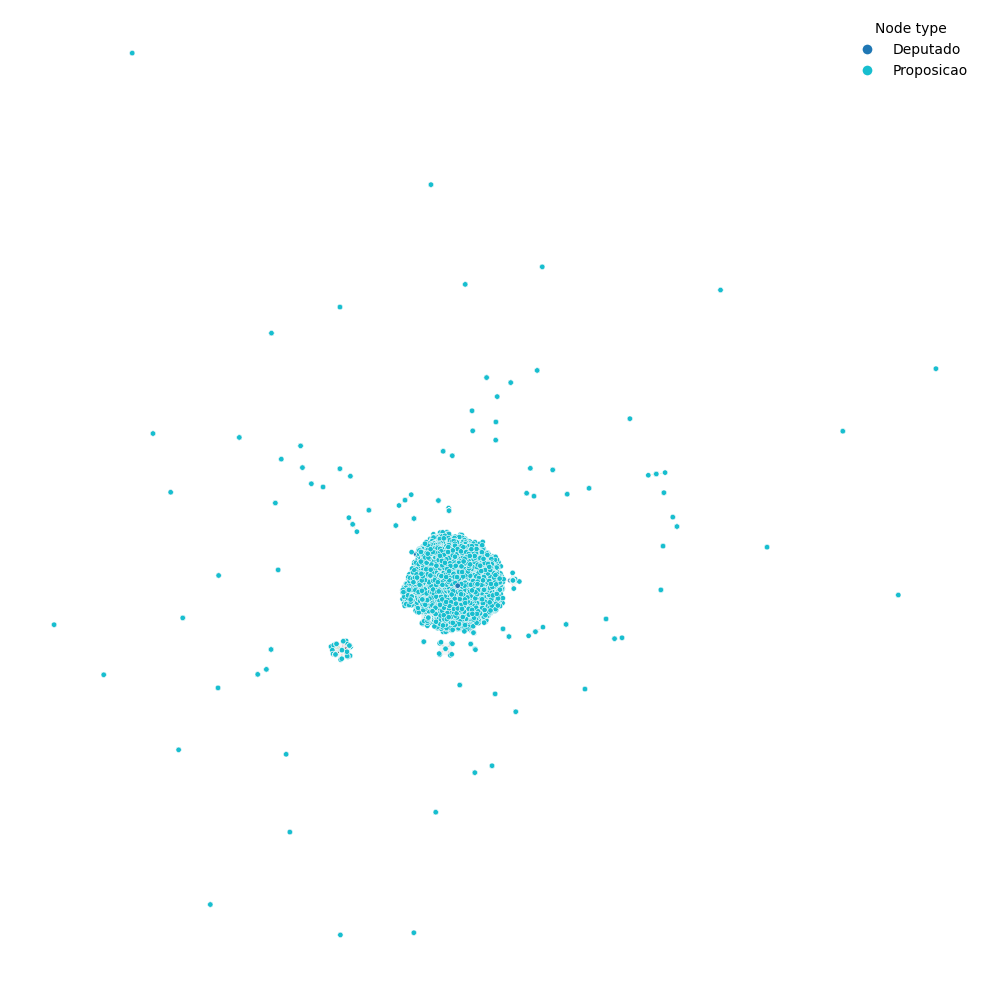

In [94]:
view_graph(g)